# Principal Component Analysis (PCA): Seoul, Busan, and Jeju daily temperatures

## Basics of PCA

The mathematical details of PCA have been covered in class. Here, we only briefly remind some basic concepts and equations.

PCA is a dimensionality reduction technique. Given some original data matrix $X$, we transform it into a new coordinate system, where the bases are directed according to the variability in the data. This transformation ensures that the first basis is along the directions of largest variation in the data, the second along the direction of second-most variation while being orthogonal to the first, and so on.

Assume that $X$ is a matrix of dimensions $n\times k$, where $n$ is the number of samples (i.e., the number of time steps), and $k$ is the dimensionality of each data sample (for example, number of different stations where we measure temperature). Each column of $X$ is one time series. Each row of $X$ is one data sample. In PCA, it is not easy to keep track of the dimensions of the different matrices and vectors. So here, I specify the dimensionality of each new term when introducing it. Note also that vectors are defined as column vectors.

The first step is to make all columns of $X$ zero-mean by removing the column means ($\mu$, vector of length $k$). We will denote this centered matrix $\tilde{X}$ ($n\times k$).

$\begin{equation}
\tilde{X} = X-1_{n}\mu^{T}
\end{equation}$

where $1_{n}$ is a vector of all ones and of length $n$, and the superscript $T$ denotes the transpose. From $\tilde{X}$, we compute the empirical covariance $S$ ($k\times k$):

$\begin{equation}
S = \frac{1}{n-1} \tilde{X}^{T}\tilde{X}
\end{equation}$

The covariance matrix $S$ is the key to perform PCA on $\tilde{X}$. To avoid complications, we assume that $S$ is of full rank. We perform the spectral decomposition of $S$ to find its eigenvectors $e_{j}$ (vectors of length $k$) and associated eigenvalues $\lambda_{j}$ for $j=1,...,k$.

$\begin{equation}
S = V\Lambda V^{T}
\end{equation}$

where $V$ ($k \times k$) has one eigenvector in each of its columns, and $\Lambda$ is a diagonal matrix with all the eigenvalues along the diagonal. We assume that the eigenvalues are sorted in descending order: $\lambda_{1}\geq\lambda_{2}\geq...\geq\lambda_{k}$. The $e_{j}$ are the fixed "patterns" capturing the directions of variation in the original data $\tilde{X}$, also commonly called "Empirical Orthogonal Functions" (EOFs). Each $\lambda_{j}$ quantifies the proportion of the variance captured along the direction $e_{j}$.

We can project the data $\tilde{X}$ on the eigenvectors to get the vectors of "principal component coefficients" $\alpha_{j}$, which are also called "expansion coefficients". There are $k$ vectors $\alpha_{j}$, each of length $n$. Thus, each $\alpha_{j}$ is a time series. The projection is simply:

$\begin{equation}
A = \tilde{X}V
\end{equation}$

where the matrix $A$ ($n\times k$) has one $\alpha_{j}$ time series in each of its columns.

This implies that the data $\tilde{X}$ can be reconstructed from the eigenvectors and expansion coefficients. In particular, the data sample at time step $i$ is the linear combination of all the eigenvectors, and the coefficients of the combination are given by the values $\alpha_{i,j}$ for $j=1,...,k$:

$\begin{equation}
\tilde{x}_{i} = \sum_{j=1}^{k}\alpha_{i,j} e_{j}
\end{equation}$

Doing this for all time step at once:

$\begin{equation}
\tilde{X} = \sum_{j=1}^{k}\alpha_{j} e_{j}^{T}
\end{equation}$

And this can be written in matrix notation as:

$\begin{equation}
\tilde{X} = A V^{T}
\end{equation}$

## Temperature data

In this notebook, we will use PCA to analyze daily temperature data from Seoul, Busan, and Jeju, recorded over the last 70 years: 1954-2023. The data have been collected from the Korea Meteorological Administration data archive. The data are openly available:<br> https://data.kma.go.kr/stcs/grnd/grndTaList.do?pgmNo=70

We have 3 dimensions (stations of Seoul, Busan, Jeju), and we have 25567 daily time steps. Thus:

$\begin{equation}
\left\{ 
  \begin{aligned}
    &k=3 \\
    &n=25567
  \end{aligned}
\right.
\end{equation}$

We start by importing some python packages needed for the analysis. We also import some functions stored in a separate code file.

In [1]:
import os
import sys
import csv
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from procfuncs import datestring_to_datedec

We specify the file names, as well as some parameters. And we load the data.

In [2]:
### Files to load ###
floc_sl = 'seoul_tday_1954to2023.csv'
floc_bs = 'busan_tday_1954to2023.csv'
floc_jj = 'jeju_tday_1954to2023.csv'

### Parameters ###
ic_date      = 0 #column for date
ic_tday      = 2 #column for daily mean temperature
col0         = 'navy'
col1         = 'tomato'
col2         = 'green'
cols_eigvecs = ['aqua','lime','magenta']

### Load data ###
data_sl    = np.genfromtxt(floc_sl,dtype=str,delimiter=',')
tmdaily_sl = np.array([datestring_to_datedec(entry[2:-1]) for entry in data_sl[:,ic_date]])
tday_sl    = data_sl[:,ic_tday].astype(float)
data_bs    = np.genfromtxt(floc_bs,dtype=str,delimiter=',')
tmdaily_bs = np.array([datestring_to_datedec(entry[2:-1]) for entry in data_bs[:,ic_date]])
tday_bs    = data_bs[:,ic_tday].astype(float)
data_jj    = np.genfromtxt(floc_jj,dtype=str,delimiter=',')
tmdaily_jj = np.array([datestring_to_datedec(entry[2:-1]) for entry in data_jj[:,ic_date]])
tday_jj    = data_jj[:,ic_tday].astype(float)
ntsteps    = len(tmdaily_sl)

It is useful to visualize the temperature data. Let's make a scatterplot where we show, for each day, the temperature in Seoul and Busan, in Seoul and Jeju, and in Busan and Jeju.

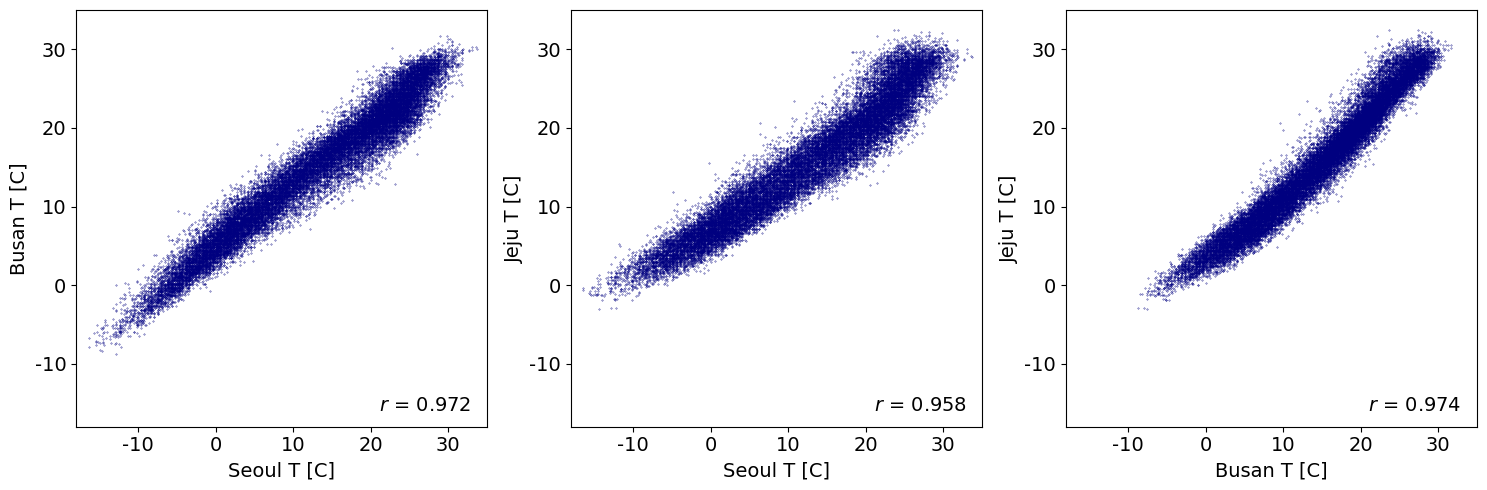

In [3]:
### Visualize temperature data ###
pl_lims  = [-18,35]
pl_ticks = np.arange(-10,30+1,10).astype(int)
lspl     = [[tday_sl,tday_bs],[tday_sl,tday_jj],[tday_bs,tday_jj]]
pl_labs  = [['Seoul T [C]','Busan T [C]'],['Seoul T [C]','Jeju T [C]'],['Busan T [C]','Jeju T [C]']]
fig = plt.figure(figsize=[15,5])
for ii in range(len(lspl)):
    ax = plt.subplot(1,3,ii+1)
    ax.scatter(lspl[ii][0],lspl[ii][1],marker='o',c=col0,s=0.08)
    tempr = np.round(float(np.corrcoef(lspl[ii][0],lspl[ii][1])[0,1]),3)
    ax.set_xlim(pl_lims)
    ax.set_ylim(pl_lims)
    ax.set_xticks(pl_ticks,labels=pl_ticks,fontsize=14)
    ax.set_yticks(pl_ticks,labels=pl_ticks,fontsize=14)
    ax.set_xlabel(pl_labs[ii][0],fontsize=14)
    ax.set_ylabel(pl_labs[ii][1],fontsize=14)
    ax.text(pl_lims[1]-14,pl_lims[0]+2,r'$r$ = '+str(tempr),fontsize=14)
fig.tight_layout()

Clearly, there is a strong correlation between all three stations ($r>0.95$). Seoul temperature is most variable, ranging between -15C and 30C approximately. The highest temperatures in all three stations are comparable. But, compared to Seoul, the lowest temperatures are milder in Busan, and even more in Jeju. It also appears that Seoul is better correlated with Busan than Jeju: the points are better aligned along a straight line. Busan is approximately equally correlated with Seoul and Jeju.

Now, let's start by centering our data. Remember: it is important that all the columns of $\tilde{X}$ have zero-mean. Thus, we need to take the mean temperature at each station, and subtract it from the corresponding station time series. Once this is done, we form $\tilde{X}$ by stacking both columns together.

In [4]:
### Center data ###
mntday_sl   = np.mean(tday_sl)
mntday_bs   = np.mean(tday_bs)
mntday_jj   = np.mean(tday_jj)
tday_sl_ctr = tday_sl-mntday_sl
tday_bs_ctr = tday_bs-mntday_bs
tday_jj_ctr = tday_jj-mntday_jj

### Data matrix ###
xmat_tilde   = np.column_stack((tday_sl_ctr,tday_bs_ctr,tday_jj_ctr))
dimn,dimk    = np.shape(xmat_tilde) #dimensions: number of data points and number of variables

Compute the covariance matrix. Note that in python, $@$ is the matrix multiplication operator. The operator $*$ can be used for element-wise multiplication.

In [5]:
### Covariance matrix ###
covmat = (1/(dimn-1)) * (xmat_tilde.T @ xmat_tilde)

And now, do the eigendecomposition to compute the matrix $V$ ($k\times k$). For this, we use the built-in method from the numpy linear algebra library.

In [6]:
### Eigendecomposition ###
eigvals,eigvecs_c = np.linalg.eig(covmat)

Note that, conveniently, this command returns eigenvalues and eigenvectors sorted such that $\lambda_{1}\geq\lambda_{2}\geq...\geq\lambda_{k}$. The eigenvecotrs are the columns of eigvecs_c (which is why I add a \_c postscript to the variable).

We have three eigenvector-eigenvalue pairs. We can look at the proportion of variance captured by each direction. This is given by the values of the eigenvalues.

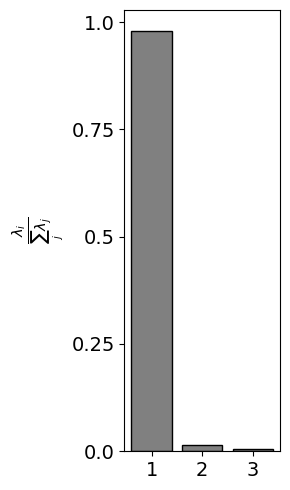

In [8]:
pltemp = eigvals/np.sum(eigvals)
fig = plt.figure(figsize=[3,5])
ax = plt.subplot(111)
ax.bar(np.arange(1,len(eigvals)+1,1),pltemp,edgecolor='k',facecolor='grey')
ax.set_ylabel(r'$\frac{\lambda_{i}}{\sum_{j}\lambda_{j}}$',fontsize=15)
ax.set_yticks(np.arange(0,1+0.01,0.25),labels=np.round(np.arange(0,1+0.01,0.25),2),fontsize=14)
ax.set_xticks(np.arange(1,len(eigvals)+1,1),labels=np.arange(1,len(eigvals)+1,1),fontsize=14)
fig.tight_layout()

As expected, this confirms that most of the variability in the data is aligned with a single direction. The contributions of the second and third eigenvectors are very small.

Remember that the three eigenvectors provide a set of new bases. We can visualize the directions of the three bases in the real-world coordinate system, which is defined by the temperatures of Seoul, Busan, and Jeju. The three eigenvectors are orthogonal to each other, but this is difficult to show in two-dimensional figures. Note that each eigenvector has a component in each of the 3 directions (Seoul, Busan, and Jeju temperature). Here, we show the eigenvector length as proportional to $\sqrt{\lambda_{j}}$.


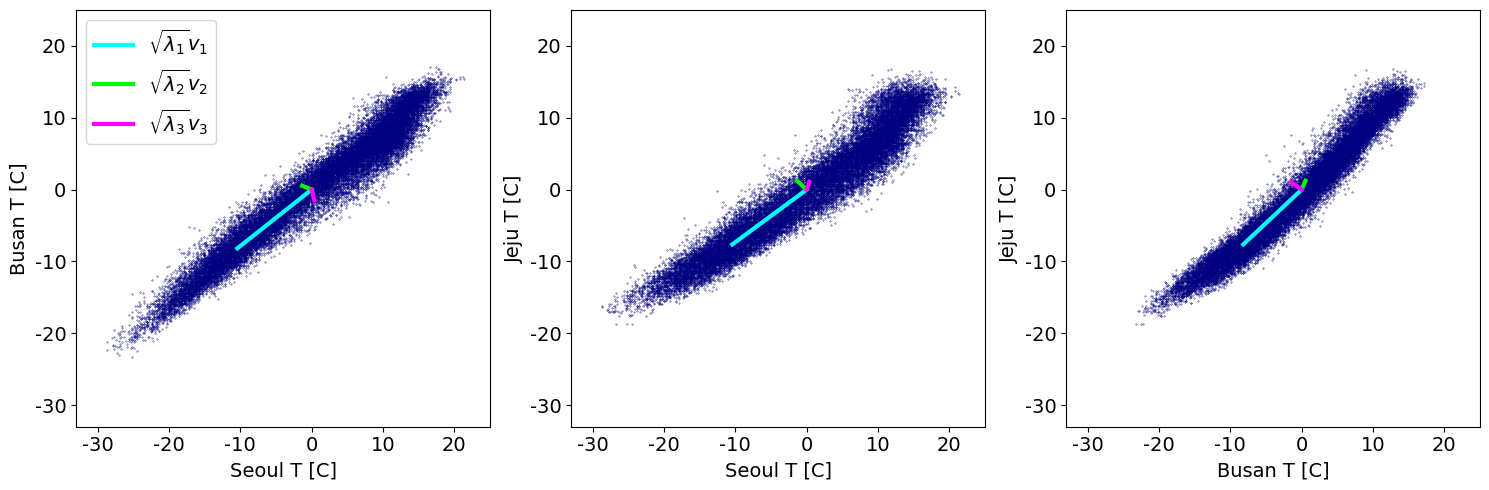

In [9]:
### Visualize eigenvectors ###
pl_lims   = [-33,25]
pl_ticks  = np.arange(-30,20+1,10).astype(int)
lspl      = [[tday_sl_ctr,tday_bs_ctr],[tday_sl_ctr,tday_jj_ctr],[tday_bs_ctr,tday_jj_ctr]]
lseiginds = [[0,1],[0,2],[1,2]]
pl_labs   = [['Seoul T [C]','Busan T [C]'],['Seoul T [C]','Jeju T [C]'],['Busan T [C]','Jeju T [C]']]
fig = plt.figure(figsize=[15,5])
for ii in range(len(lspl)):
    ax = plt.subplot(1,3,ii+1)
    ax.scatter(lspl[ii][0],lspl[ii][1],marker='o',c=col0,s=0.08)
    ax.plot([0,eigvecs_c[lseiginds[ii][0],0]*np.sqrt(eigvals[0])],[0,eigvecs_c[lseiginds[ii][1],0]*np.sqrt(eigvals[0])],c=cols_eigvecs[0],linewidth=3.0,label=r'$\sqrt{\lambda_{1}}v_{1}$')
    ax.plot([0,eigvecs_c[lseiginds[ii][0],1]*np.sqrt(eigvals[1])],[0,eigvecs_c[lseiginds[ii][1],1]*np.sqrt(eigvals[1])],c=cols_eigvecs[1],linewidth=3.0,label=r'$\sqrt{\lambda_{2}}v_{2}$')
    ax.plot([0,eigvecs_c[lseiginds[ii][0],2]*np.sqrt(eigvals[1])],[0,eigvecs_c[lseiginds[ii][1],2]*np.sqrt(eigvals[1])],c=cols_eigvecs[2],linewidth=3.0,label=r'$\sqrt{\lambda_{3}}v_{3}$')
    tempr = np.round(float(np.corrcoef(lspl[ii][0],lspl[ii][1])[0,1]),3)
    ax.set_xlim(pl_lims)
    ax.set_ylim(pl_lims)
    ax.set_xticks(pl_ticks,labels=pl_ticks,fontsize=14)
    ax.set_yticks(pl_ticks,labels=pl_ticks,fontsize=14)
    ax.set_xlabel(pl_labs[ii][0],fontsize=14)
    ax.set_ylabel(pl_labs[ii][1],fontsize=14)
    if(ii==0):
        ax.legend(loc='best',fontsize=14)
fig.tight_layout()

As you can see, the first eigenvector aligns well with the variability in all directions. The second and third eigenvectors align with the second and third directions of variability, subject to orthogonality between the eigenvectors.

Now, we can project our data matrix onto the eigenvectors to compute the principal component coefficients. Remember, this will give us a matrix $A$ ($n\times k$).

In [10]:
### Project data onto the eigenvectors ###
pccfs_c = xmat_tilde @ eigvecs_c

The PC coefficient time series are in the columns of $A$ (called pccfs\_c here). The eigenvectors essentially give us a new coordinate system in which we can see the data. The PC coefficients are the coordinates of the data in this new coordinate system. Thus, we can visualize our data in eigenspace!

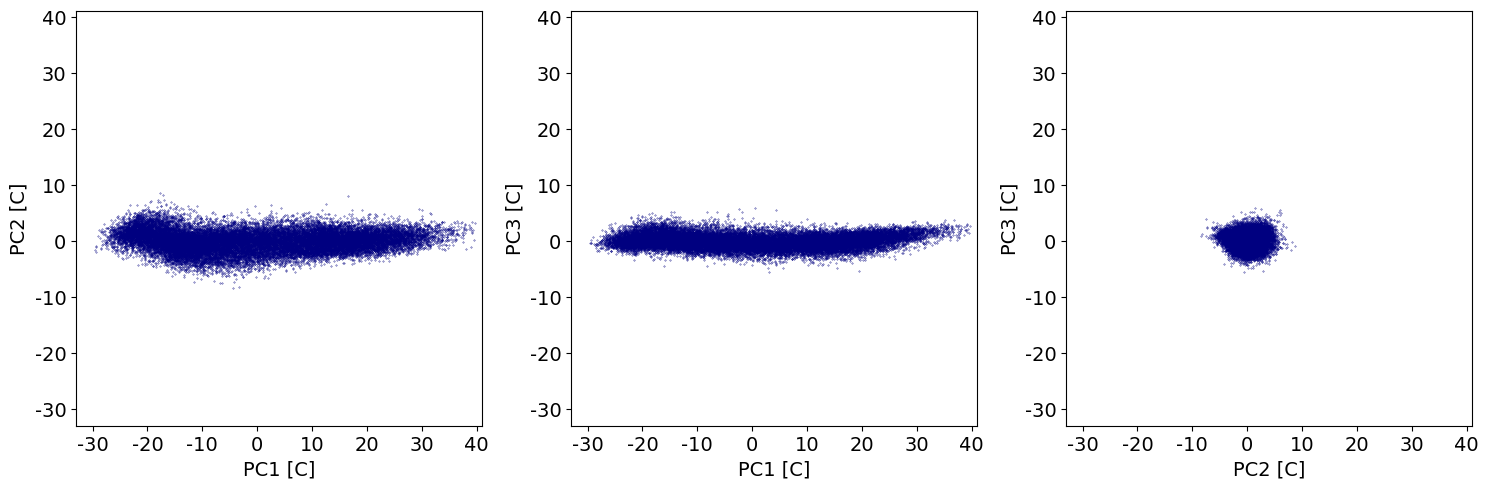

In [11]:
### Figure: visualize projection ###
pl_lims  = [-33,41]
pl_ticks = np.arange(-30,40+1,10).astype(int)
lspl     = [[pccfs_c[:,0],pccfs_c[:,1]],[pccfs_c[:,0],pccfs_c[:,2]],[pccfs_c[:,1],pccfs_c[:,2]]]
pl_labs  = [['PC1 [C]','PC2 [C]'],['PC1 [C]','PC3 [C]'],['PC2 [C]','PC3 [C]']]
fig = plt.figure(figsize=[15,5])
for ii in range(len(lspl)):
    ax = plt.subplot(1,3,ii+1)
    ax.scatter(lspl[ii][0],lspl[ii][1],marker='o',c=col0,s=0.08)
    ax.set_xlim(pl_lims)
    ax.set_ylim(pl_lims)
    ax.set_xticks(pl_ticks,labels=pl_ticks,fontsize=14)
    ax.set_yticks(pl_ticks,labels=pl_ticks,fontsize=14)
    ax.set_xlabel(pl_labs[ii][0],fontsize=14)
    ax.set_ylabel(pl_labs[ii][1],fontsize=14)
fig.tight_layout()

Notice that the data is maximally spread in the direction of the first eigenvector, and very little in the directions of the two other ones.

Finally, it is straightforward to reconstruct our data from the PCs and their associated PC coefficients. We can reconstruct a truncated version of the data by using only a subset of the eigenvectors. We can see how the data is progressively better reconstructed by using more eigenvectors. If we use all eigenvectors, this should give us back exactly the original data (at machine error precision). Doing this is a good way to check that you did all the steps of PCA correctly.

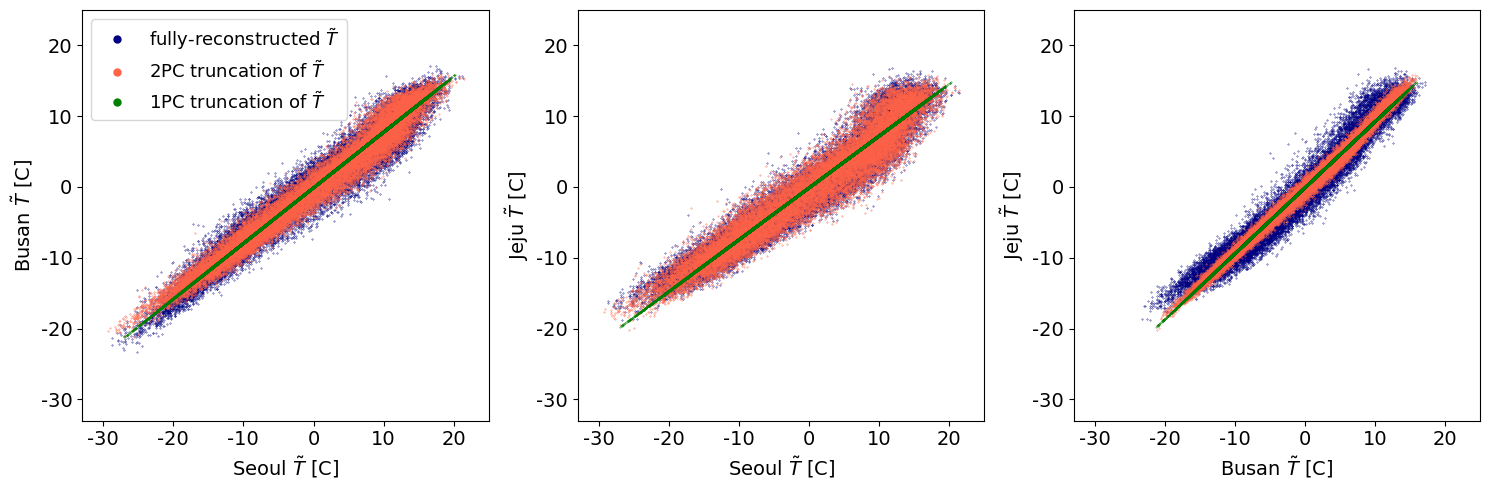

In [12]:
### Reconstruct original data ###
xrec_0 = np.array([pccfs_c[:,0]]).T @ np.array([eigvecs_c[:,0]])
xrec_1 = xrec_0 + np.array([pccfs_c[:,1]]).T @ np.array([eigvecs_c[:,1]])
xrec_f  = pccfs_c @ eigvecs_c.T

### Figure: visualize reconstruction ###
pl_lims  = [-33,25]
pl_ticks = np.arange(-30,20+1,10).astype(int)
lspl     = [[0,1],[0,2],[1,2]]
pl_labs  = [[r'Seoul $\tilde{T}$ [C]',r'Busan $\tilde{T}$ [C]'],
            [r'Seoul $\tilde{T}$ [C]',r'Jeju $\tilde{T}$ [C]'],
            [r'Busan $\tilde{T}$ [C]',r'Jeju $\tilde{T}$ [C]']]
fig = plt.figure(figsize=[15,5])
for ii in range(len(lspl)):
    ax = plt.subplot(1,3,ii+1)
    ax.scatter(xrec_f[:,lspl[ii][0]],xrec_f[:,lspl[ii][1]],marker='o',c=col0,s=0.08)
    ax.scatter(xrec_1[:,lspl[ii][0]],xrec_1[:,lspl[ii][1]],marker='o',c=col1,s=0.08)
    ax.scatter(xrec_0[:,lspl[ii][0]],xrec_0[:,lspl[ii][1]],marker='o',c=col2,s=0.08)
    ax.set_xlim(pl_lims)
    ax.set_ylim(pl_lims)
    ax.set_xticks(pl_ticks,labels=pl_ticks,fontsize=14)
    ax.set_yticks(pl_ticks,labels=pl_ticks,fontsize=14)
    ax.set_xlabel(pl_labs[ii][0],fontsize=14)
    ax.set_ylabel(pl_labs[ii][1],fontsize=14)
    if(ii==0):
        point0 = Line2D([-1e20,-1e19],[0,0],marker='o',markersize=5,markerfacecolor=col0,markeredgecolor=col0,linestyle='')
        point1 = Line2D([-1e20,-1e19],[0,0],marker='o',markersize=5,markerfacecolor=col1,markeredgecolor=col1,linestyle='')
        point2 = Line2D([-1e20,-1e19],[0,0],marker='o',markersize=5,markerfacecolor=col2,markeredgecolor=col2,linestyle='')
        ax.legend([point0,point1,point2],[r'fully-reconstructed $\tilde{T}$',r'2PC truncation of $\tilde{T}$',r'1PC truncation of $\tilde{T}$'],loc='best',fontsize=13)
fig.tight_layout()

In this example, it is clear that only the first eigenvector allows to represent well the temperature at the three stations. This may seem trivial, but you should understand here that the three green clouds of points are computed using a single basis: the first eigenvector. Using the second eigenvector and its PC time series allows to represent most of the fine-scale variability around the dominating pattern. Finally, it appears that the third PC serves to represent some variability in the Seoul-Busan and in the Busan-Jeju relation, but almost none of the variability in the Seoul-Jeju relation.